<a href="https://colab.research.google.com/github/NicoEssi/GAN_Synthetic_Medical_Image_Augmentation/blob/master/Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

We start by importing all neccessary dependencies, followed up setting up the Kaggle library to download and unzip our dataset. To acquire the Kaggle API key file; simply log into Kaggle, go to "My Account", and you can download the API key file from that page. When the notebook prompts you to choose a file; choose the Kaggle API key file.

In [1]:
# Functionality
import os
from glob import glob
from google.colab import files

# Basics
import numpy as np
import pandas as pd

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

TensorFlow 2.x selected.


In [0]:
# Install Kaggle library
!pip install -q kaggle
!mkdir -p ~/.kaggle

# Upload Kaggle API key file (might have to rerun to work)
files.upload()

In [0]:
# Download our dataset
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# Unzip it
!unzip skin-cancer-mnist-ham10000.zip

# Processing

In [5]:
# Set base directory, importing to later identify image paths
base_skin_dir = "/content/"

# Take a glimpse at the metadata of our images
df_meta = pd.read_csv(os.path.join(base_skin_dir,'HAM10000_metadata.csv'))
df_meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [0]:
# Functionality so that we can find the image path for each metadata entry
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x 
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# Functionality so that we can identify the type of lesion
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [7]:
# First of all, we read in our metadata
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Secondly, we map the image path directory for the entry
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)

# Thirdly, we specify the type of lesion for the entry
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get)

# Finally, we encode the type of lesion - to later use as label as onehotencoded
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
2080,HAM_0002375,ISIC_0027442,mel,histo,80.0,male,neck,/content/HAM10000_images_part_1/ISIC_0027442.jpg,Melanoma,5
9610,HAM_0004430,ISIC_0032789,nv,consensus,NaN,unknown,unknown,/content/HAM10000_images_part_2/ISIC_0032789.jpg,Melanocytic nevi,4
3687,HAM_0003841,ISIC_0028349,nv,follow_up,30.0,male,trunk,/content/HAM10000_images_part_1/ISIC_0028349.jpg,Melanocytic nevi,4


In [8]:
# Overview of our data
tile_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0005263,ISIC_0030221,nv,histo,male,back,/content/HAM10000_images_part_2/ISIC_0030494.jpg,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


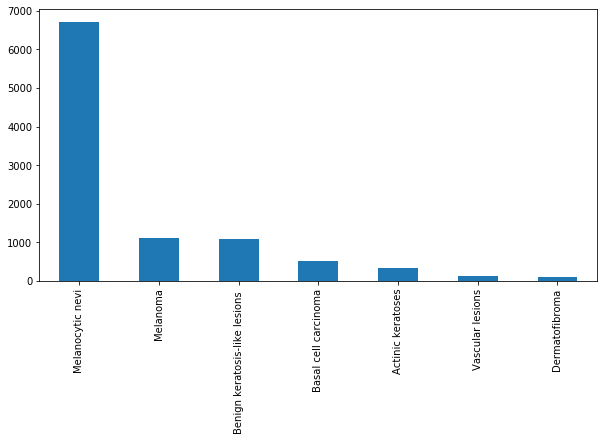

In [9]:
# Now we look at the distribution of our dataset, to identify which
# categories we will use for our CNN classification and category for GAN
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [0]:
# Let's choose Melanoma, benign lesions, and the carcinoma for our CNN and
# the carcinoma for our GAN synthetic data generation, due to its having
# significantly less data in proportion to the former two categories.
categories = ['mel', 'bkl', 'bcc']
tile_df = tile_df[tile_df.dx.isin(categories)]

# Load in all of the images for each entry
from skimage.io import imread
tile_df['image'] = tile_df['path'].map(imread)

In [11]:
# Image size distributions
tile_df['image'].map(lambda x: x.shape).value_counts()

(450, 600, 3)    2726
Name: image, dtype: int64

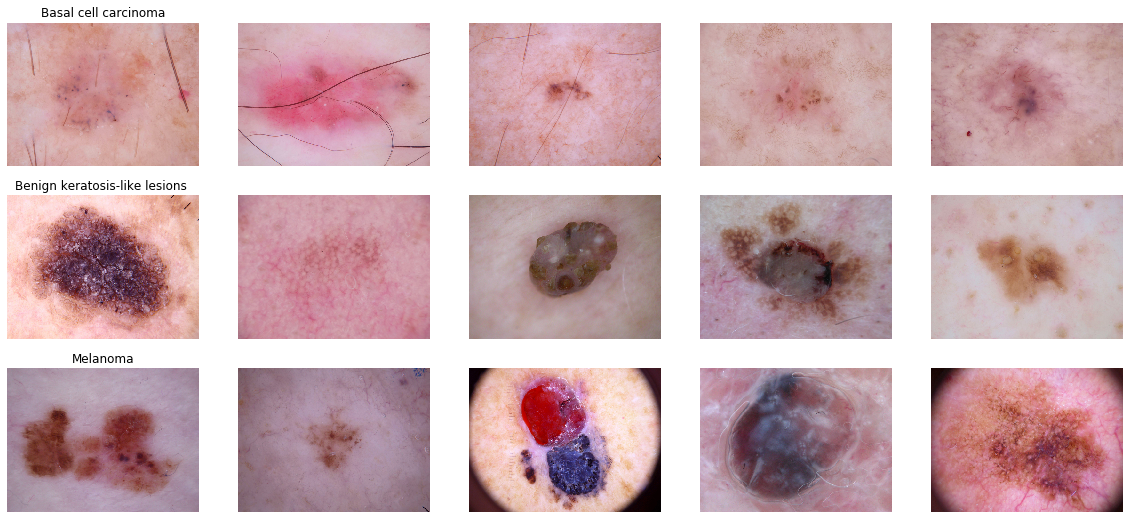

In [12]:
# We sample 5 images from each category for visual inspection
n_samples = 5 # How many samples we want to see from each category

# Code for visualization
fig, m_axs = plt.subplots(3, n_samples, figsize = (4*n_samples, 3*3))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [13]:
# RGB means for greater insight into our dataset
rgb_info_df = tile_df.apply(lambda x: pd.Series({'{}_mean'.format(k): v for k, v in 
                                  zip(['Red', 'Green', 'Blue'], 
                                      np.mean(x['image'], (0, 1)))}),1)
gray_col_vec = rgb_info_df.apply(lambda x: np.mean(x), 1)
for c_col in rgb_info_df.columns:
    rgb_info_df[c_col] = rgb_info_df[c_col]/gray_col_vec
rgb_info_df['Gray_mean'] = gray_col_vec
rgb_info_df.sample(3)

,Red_mean,Green_mean,Blue_mean,Gray_mean
2299,1.282380,0.901997,0.815623,156.348577
478,1.092408,0.961204,0.946389,178.228278
302,1.044798,0.936924,1.018279,159.596340


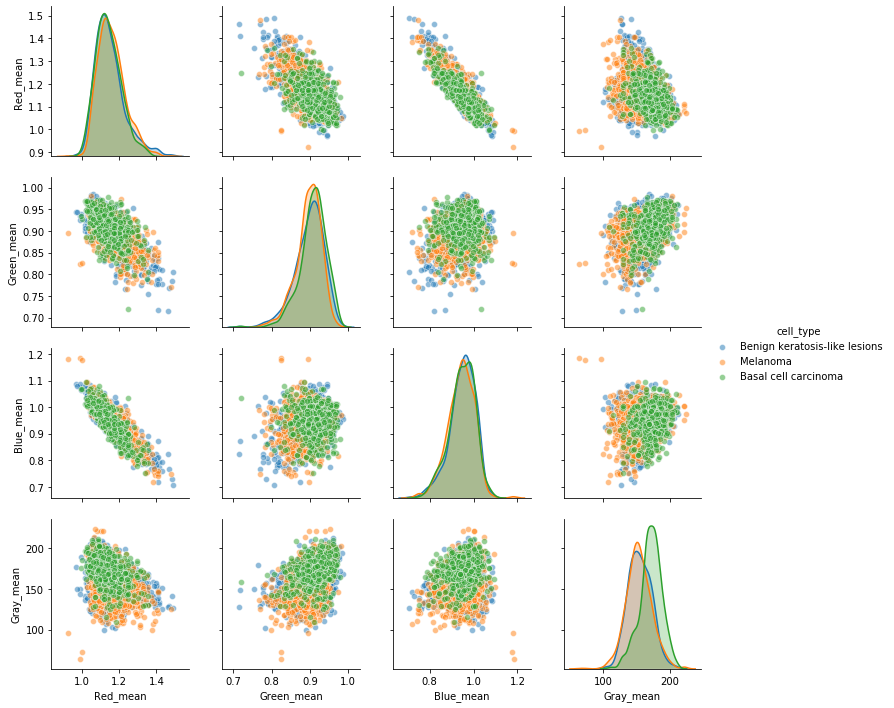

In [14]:
# Visualization of the RGB means, for greater insight into our dataset
for c_col in rgb_info_df.columns:
    tile_df[c_col] = rgb_info_df[c_col].values

sns.pairplot(tile_df[['Red_mean', 'Green_mean', 'Blue_mean', 'Gray_mean', 'cell_type']], 
             hue='cell_type', plot_kws = {'alpha': 0.5})

# Data Preparation

In [0]:
# Global parameters
TEST_IMG_COUNT = 800
IMG_SIZE = (299, 299) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 64 # [1, 8, 16, 24]
EPOCHS = 50
RGB_FLIP = 1 # should RGB be flipped when rendering images
#SAMPLE_PER_GROUP = 300

In [19]:
from sklearn.model_selection import train_test_split

# Splitting up our data into training and testing set
df_train, df_test = train_test_split(tile_df, # Feel free to add stratification
                                     test_size = 0.3)

df_train = df_train.reset_index(drop = True)
# Possibly ensure that the size is divisible by batch size if errors ensue

# Uncomment if you wish to have equal sample groups
#df_train = df_train.groupby('cell_type').\
#                    apply(lambda x: x.sample(SAMPLE_PER_GROUP,
#                                             replace=True)).\
#                    reset_index(drop = True)

# df_train = df_train.reset_index(drop=True)
# df_test = df_test.reset_index(drop=True)

# Checking volume for each category after the split
print("train mel: " + str(len(df_train[df_train.dx == "mel"])) + # Melanoma
      "\ntrain bkl: " + str(len(df_train[df_train.dx == "bkl"])) + # Beign keratosis-like lesions
      "\ntrain bcc: " + str(len(df_train[df_train.dx == "bcc"])) + # Basal cell carcinoma
      "\ntrain size: " + str(df_train.shape[0]))

print("\ntest mel: " + str(len(df_test[df_test.dx == "mel"])) +
      "\ntest bkl: " + str(len(df_test[df_test.dx == "bkl"])) +
      "\ntest bcc: " + str(len(df_test[df_test.dx == "bcc"])) +
      "\ntest size: " + str(df_test.shape[0]))

train mel: 748
train bkl: 785
train bcc: 375
train size: 1908

test mel: 365
test bkl: 314
test bcc: 139
test size: 818


In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Arguments for our training data generator
dg_args = dict(featurewise_center = False, 
               samplewise_center = False,
               rescale = 1./255,
               rotation_range = 45, 
               width_shift_range = 0.1, 
               height_shift_range = 0.1, 
               shear_range = 0.01,
               zoom_range = [0.9, 1.25],  
               brightness_range = [0.7, 1.3],
               horizontal_flip = True, 
               vertical_flip = False,
               fill_mode = 'reflect',
               data_format = 'channels_last'
#               preprocessing_function = preprocess_input
               )

# Arguments for our testing data generator
test_args = dict(rescale = 1./255,
                 fill_mode = 'reflect',
                 data_format = 'channels_last'
#                 preprocessing_function = preprocess_input
                 )

# Setting up the image data generators
core_idg = ImageDataGenerator(**dg_args)
test_idg = ImageDataGenerator(**test_args)

In [0]:
# Consult Keras Image Preprocessing documentation,
# specifically section "flow_from_dataframe"
# https://keras.io/preprocessing/image/

def flow_from_dataframe(img_data_gen, raw_df, path_col, y_col, **dflow_args):

    in_df = raw_df.copy()
    in_df[path_col] = in_df[path_col].map(str)
    in_df[y_col] = in_df[y_col].map(lambda x: np.array(x))
    df_gen = img_data_gen.flow_from_dataframe(in_df, 
                                              x_col=path_col,
                                              y_col=y_col,
                                              class_mode = 'raw',
                                              **dflow_args)
    
    # posthoc correction
    df_gen._targets = np.stack(df_gen.labels, 0)
    return df_gen

In [22]:
# Setting up training data generator and loader
train_gen = flow_from_dataframe(core_idg, df_train, 
                                path_col = 'path',
                                y_col = 'cell_type_idx', 
                                target_size = IMG_SIZE,
                                color_mode = 'rgb',
                                batch_size = BATCH_SIZE)

# Setting up testing data generator and loader
test_x, test_y = next(flow_from_dataframe(test_idg, 
                                            df_test, 
                                            path_col = 'path',
                                            y_col = 'cell_type_idx', 
                                            target_size = IMG_SIZE,
                                            color_mode = 'rgb',
                                            batch_size = TEST_IMG_COUNT))

# Checking shape
print(test_x.shape, test_y.shape)

Found 1908 validated image filenames.
Found 818 validated image filenames.
(800, 299, 299, 3) (800,)


x (64, 299, 299, 3) float32 0.0 1.0
y (64,) int64 1 5
[1 5 1 5 5 1 2 5 2 2 1 2 5 2 2 5 5 5 5 2 5 5 2 1 2 2 1 5 2 2 2 2 5 2 2 1 5
 5 2 5 2 5 2 5 5 5 1 1 2 5 5 5 5 2 2 5 5 2 1 5 5 2 5 5] , labels


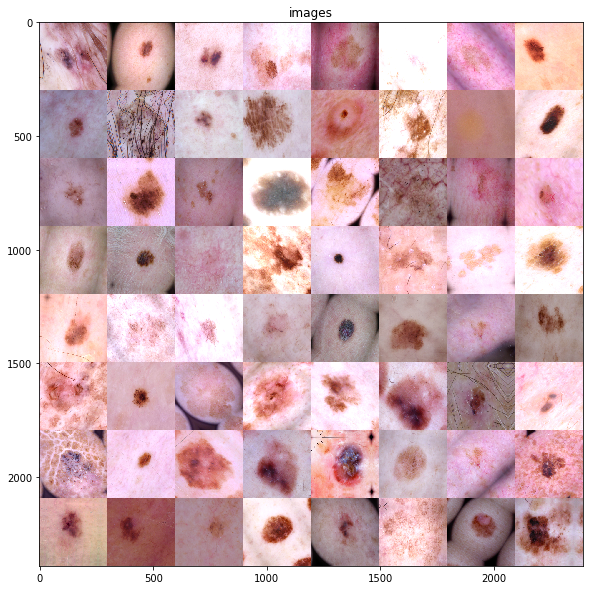

In [23]:
from skimage.util import montage

# Acquire next batch of data from our generator
t_x, t_y = next(train_gen)

# Print out their shapes
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

# Visualize them using the montage utility
fig, (ax1) = plt.subplots(1, 1, figsize = (10, 10))
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb((t_x-t_x.min())/(t_x.max()-t_x.min()))[:, :, ::RGB_FLIP])
ax1.set_title('images')

# Show the labels for this batch
print(t_y, ", labels")

# Convolutional Neural Network Setup

In [0]:
# Functionality to ease the clutter of constructing the CNN
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

# Convolutional neural network construction
model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [0]:
# Compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=[X_valid, y_valid])
score = model.evaluate(X_test, y_test)

# Deep Convolutional GAN

In [0]:
codings_size = 100

# Generator construction
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])

# Discriminator construction
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[32, 32, 3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

# Final construction and compilation
dcgan = keras.models.Sequential([generator, discriminator])
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
dcgan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [0]:
# Function to train our DCGAN
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers

    # may the epochs commence
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for X_batch in dataset:

            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

        plot_multiple_images(generated_images, 8) # generate images for viz.
        plt.show() # visualize our generated images

In [0]:
# Training our DCGAN
train_gan(dcgan, dataset, batch_size, codings_size, n_epochs=1)